$$ \LaTeX \text{ command declarations here.}
\newcommand{\N}{\mathcal{N}}
\newcommand{\R}{\mathbb{R}}
\renewcommand{\vec}[1]{\mathbf{#1}}
\newcommand{\norm}[1]{\|#1\|_2}
\newcommand{\d}{\mathop{}\!\mathrm{d}}
\newcommand{\qed}{\qquad \mathbf{Q.E.D.}}
\newcommand{\vx}{\mathbf{x}}
\newcommand{\vy}{\mathbf{y}}
\newcommand{\vt}{\mathbf{t}}
\newcommand{\vb}{\mathbf{b}}
\newcommand{\vw}{\mathbf{w}}
$$

In [1]:
%matplotlib inline
from Lec07 import *

# EECS 445: Introduction to Machine Learning
## Lecture 06:  Logistic Regression 
* Instructor:  **Jacob Abernethy** and **Jia Deng**
* Date:  September 26, 2016

*Lecture Exposition Credit:*  Benjamin Bray, Saket Dewangan

## Outline

- Concept of Classification
- Logistic Regression
    - Intuition, Motivation
    - Newton's Method
    
## Reading List

- Suggested:
    - **[MLAPP]**, Chapter 8: Logistic Regression    

> In this lecture, we will move from regression to classification.Unlike of predicting some value for data in regression, we predict what category data belongs to in classification. And we will introduce logistic regression. In logistic regression, we will show how to find the optimal coefficients $\vw$ using Newton's method.

## Review: Supervised Learning

- Goal
    - Given data $X$ in feature sapce and the labels $Y$
    - Learn to predict $Y$ from $X$
- Labels could be discrete or continuous
    - Discrete-valued labels:  Classification
    - Continuous-valued labels:  Regression
    
<center> <img src="images/classification-regression.png"  style="width:473px;height:213px;"> </center>

## Classification Problem

### Classification Problem: Basics

- Given an input vector $\vx$, assign it to one of $K$ distinct classes $C_k$, where $k = 1,\dots,K$.

- The case $K=2$ is **Binary Classification**
    - Label $t=1$ means $x \in C_1$
    - Label $t=0$ means $x \in C_2$ (or sometimes $t=-1$)
    
- **Training:**  Learn a classifier $y(\vx)$ from data,
    $$ \text{Training Data} \quad \{ (\vx_1, t_1), \dots, (\vx_N, t_N) \} \implies \text{Classifier} \ y(\vx) $$
    
- **Prediction:** Predict labels of new data,
    $$ \text{New Data} \quad \{ (\vx^{new}_1, t^{new}_1), \dots, (\vx^{new}_m, t^{new}_m) \} \stackrel{h}{\implies} \{ y(\vx^{new}_1), \dots, y(x^{new}_m) \} $$

- **Performance Evaluation:** Evaluate learned classifier on test data,
    $$ \text{Test Data} \quad \{ (\vx^{test}_1, t^{test}_1), \dots, (\vx^{test}_m, t^{test}_m) \} \stackrel{y}{\implies} \{ y(\vx^{test}_1), \dots, y(\vx^{test}_m) \} \implies \text{Error Estimate} $$
    - To estimate **classification error**, we could use e.g. *zero-one loss*:
        $$
        E = \frac{1}{m} \sum_{j=1}^m \mathbb{1} [ y(\vx^{test}_j) \neq t^{test}_j) ]
        $$
        i.e. number of misclassified data.

### Classification Problems:  Strategies

- **Nearest-Neighbors:**  Given query data $\vx$, find closest training points and do a majority vote.

- **Discriminant Functions:**  Learn a function $y(\vx)$ mapping $\vx$ to some class $C_k$.

- **Probabilistic Model:**  Learn the distributions $P(C_k | \vx)$
    - *Discriminative Models* directly model $P(C_k | \vx)$ and learn parameters from the training set.
    - *Generative Models* learn class-conditional densities $P(\vx | C_k)$ and priors $P(C_k)$

## Logistic Regression
> - Logistic Regression is a technique for **classification**!

> - We will focus on *binary* classification

### Logistic Regression: Preliminary—Logistic Sigmoid Function

- The **logistic sigmoid function** is 
    $$
    \sigma(a)
    = \frac{1}{1 + \exp(-a)}
    = \frac{\exp(a)}{1 + \exp(a)}
    $$

- Sigmoid function $\sigma(a)$ maps $(-\infty, +\infty) \to (0,1)$
<center> <img src="images/sigmoidfunc.png"  style="width:375px;height:256px;"> </center>

### Logistic Regression:  Why use Logistic Sigmoid Function?
- Prediction is picking the larger one of $P(y=1 | \vx)$ and $P(y=0 | \vx)$.

- This can be implemented by evaluating **log odds**
    $$
    a = \ln \frac{P(y=1 | \vx)}{P(y=0  | \vx)}
    $$
    
- So the prediction is
    $$
    y = 
    \left\{\begin{matrix}
    1& a\geq 0\\
    0& a< 0
    \end{matrix}\right.
    $$    
    
- Since $P(y=1 | \vx) + P(y=0  | \vx)=1$, we could solve for
    $$
    P(y=1 | \vx) = \frac{\exp(a)}{1+\exp(a)} = \sigma(a)
    $$ 
    *Logistic Function* appears!   

- A heuristic choice for log odds is a separating **hyper plane** $a = \vw^T \phi(\vx)$. So the criterion becomes
    $$
    \boxed{
    y = 
    \left\{\begin{matrix}
    1& \vw^T \phi(\vx)\geq 0, \quad \text{i.e.} \quad \sigma(\vw^T\phi(\vx)\geq 0) \geq 0.5\\
    0& \vw^T \phi(\vx)< 0 , \quad \text{i.e.} \quad \sigma(\vw^T\phi(\vx)\geq 0) < 0.5
    \end{matrix}\right.}
    $$
    
- In this case, $P(y=1 | \vx) = \sigma(\vw^T \phi(\vx))$ and $P(y=0 | \vx) = 1-\sigma(\vw^T \phi(\vx))$.

### Logistic Regression: Underlying Model

- We already have
    $$
    \begin{align}
    P(y=1 | \vx, \vw) &= \sigma(\vw^T \phi(\vx)) \\
    P(y=0 | \vx, \vw) &= 1-\sigma(\vw^T \phi(\vx))
    \end{align}
    $$

- So we could model **class posterior** using Bernoulli random variable
    $$
    y | \vx ,\vw \sim \mathrm{Bernoulli}( \sigma(\vw^T \phi(\vx)) )
    $$

- We can obtain the best paramter $\vw$ by maximizing the likelihood of the training data.(Later)

- Logistic regression is simpest discriminative model that is **linear**
in the parameters.

### Logistic Regression: Example

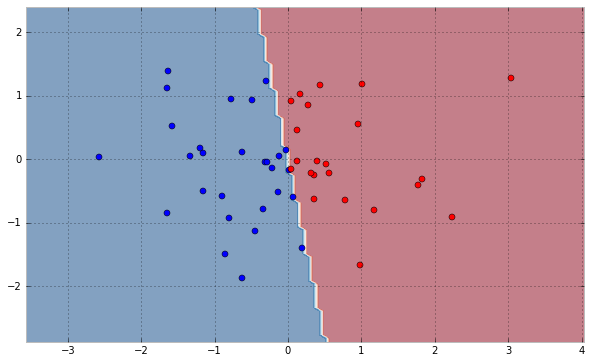

In [2]:
plt.figure(figsize=(10,6)); plot_linear_boundary();

- We could clearly see the linear boundary corresponding to $\vw^T \phi(\vx)$

### Logistic Regression:  Likelihood

- We saw before that the **likelihood** for each binary label is:
    $$
    \begin{align}
    P(y = 1 | \vx,\vw) &= \sigma(\vw^T \phi(\vx)) \\
    P(y = 0 | \vx,\vw) &= 1 - \sigma(\vw^T \phi(\vx))
    \end{align}
    $$
- With a clever trick, this
    $$
    P(y | x,w) = \sigma(\vw^T \phi(\vx))^y \cdot (1 - \sigma(\vw^T \phi(\vx)))^{1-y}
    $$

- For a data set $\{(\vx_n, t_n) \}_{n=1}^N$ where $t_n \in \{ 0,1 \}$, the **likelihood function** is
    $$
    P(\vy = \vt| \mathcal{X}, \vw) = \prod_{n=1}^N P(y=t_n | \vx_n, \vw) =\prod_{n=1}^N \sigma(\vw^T \phi(\vx_n))^{t_n} [1 - \sigma(\vw^T \phi(\vx_n))] ^{1-t_n}
    $$
    - where $\mathcal{X} = \{\vx_n \}_{n=1}^N$

- The optimal $\vw$ can be obtained by maximizing this likelihood.

- Maximum likelihood estimate $\vw_{ML}$ makse sense because $\vw_{ML}$ is the coefficient that are most likely to produce $\{t_n \}_{n=1}^N$ given $\mathcal{X}$.

- Define **negative log-likelihood** as the **loss**
    $$
    E(\vw) \triangleq -\ln P(\vy = \vt| \mathcal{X}, \vw)
    $$
- Maximizing **likelihood** is equivalent to minimizing **loss** $E(\vw)$

### Logistic Regression:  Gradient of Loss

- Loss function $E(\vw)$ can be transformed:
    $$
    \begin{align}
    E(\vw) 
    &= -\ln P(\vy = \vt| \mathcal{X}, \vw) \\
    &= -\ln \prod \nolimits_{n=1}^N \sigma(\vw^T \phi(\vx_n))^{t_n} [1 - \sigma(\vw^T \phi(\vx_n))] ^{1-t_n} \\
    &= -\sum \nolimits_{n=1}^N \left[ t_n \ln \sigma(\vw^T \phi(\vx_n)) + (1-t_n) \ln(1-\sigma(\vw^T \phi(\vx_n))) \right] \\
    &= -\sum \nolimits_{n=1}^N \left[ t_n \ln \frac{\exp(\vw^T\phi(\vx_n))}{1+\exp(\vw^T\phi(\vx_n))} + (1-t_n) \ln(\frac{1}{1+\exp(\vw^T\phi(\vx_n))}) \right] \\
    &= -\sum \nolimits_{n=1}^N \left[ t_n \ln \frac{1}{1+\exp(-\vw^T\phi(\vx_n))} + (1-t_n) \ln(\frac{1}{1+\exp(\vw^T\phi(\vx_n))}) \right] \\
    &= \boxed{\sum \nolimits_{n=1}^N \left[ t_n \ln (1+\exp(-\vw^T\phi(\vx_n))) + (1-t_n) \ln(1+\exp(\vw^T\phi(\vx_n))) \right] }\\
    \end{align}
    $$

- Gradient of loss $\nabla_\vw E(\vw)$
    $$
    \begin{align}
    \nabla_\vw E(\vw)
    &= \nabla_\vw \sum \nolimits_{n=1}^N \left[ t_n \ln (1+\exp(-\vw^T\phi(\vx_n))) + (1-t_n) \ln(1+\exp(\vw^T\phi(\vx_n))) \right] \\
    &= \sum \nolimits_{n=1}^N \left[-t_n \frac{\exp(-\vw^T\phi(\vx_n))}{1+\exp(-\vw^T\phi(\vx_n))} \phi(\vx_n)+ (1-t_n) \frac{\exp(\vw^T\phi(\vx_n))}{1+\exp(\vw^T\phi(\vx_n))} \phi(\vx_n) \right] \\
    &= \sum \nolimits_{n=1}^N \left[-t_n (1-\sigma(\vw^T\phi(\vx_n)))+ (1-t_n) \sigma(\vw^T\phi(\vx_n)) \right] \phi(\vx_n) \\
    &= \sum \nolimits_{n=1}^N \left[\sigma(\vw^T\phi(\vx_n)) - t_n \right] \phi(\vx_n) \\
    &= \boxed{ \Phi^T \left( \sigma(\Phi \vw) - \vt \right) }
    \end{align}
    $$
    of which
    $$
    \Phi = \begin{bmatrix} - & \phi(\vx_1)^T & -\\  & \vdots & \\  - & \phi(\vx_N)^T & - \end{bmatrix}_{N \times M}
    \qquad
    \sigma(\Phi \vw)=\begin{bmatrix}
    \sigma(\vw^T\phi(\vx_1))\\ 
    \vdots\\
    \sigma(\vw^T\phi(\vx_N))
    \end{bmatrix}_{N \times 1}
    \qquad
    \vt = \begin{bmatrix}
    t_1\\ 
    \vdots\\
    t_N
    \end{bmatrix}_{N \times 1}
    $$   
    
- With the gradient of loss, we could perform *gradient descent* to find $\vw_{ML}$.

- But we will use a new method by finding roots of first order derivative!

> Remark
> - Note that this gradient resembles the gradient in linear regression with least squares (Check Lecture 4)
    $$
    \begin{align}
    \text{Logistic Regression} \quad & \nabla_\vw E(\vw) = \Phi^T \left( \sigma(\Phi \vw) - \vt \right) \\
    \text{Linear Regression} \quad & \nabla_\vw E(\vw) = \Phi^T \left( \Phi \vw - \vt \right)
    \end{align}
    $$

### Newton's Method:  Overview

- First let's consider one dimension case.

- **Goal:** Finding *root* of a general function $f(x)$, i.e. solve for $x$ such that $$f(x)=0$$

- **Newton's Method:** Repeat until convergence:
    $$
    x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}
    $$

### Newton's Method:  Geometric Intuition

- Find the roots of $f(x)$ by following its **tangent lines**. The tangent line of $f(x)$ at $x_n$ has equation
    $$
    \ell(x) = f(x_n) + (x-x_n) f'(x_n)
    $$
- Set next iterate $x_{n+1}$ to be **root** of tangent line:
    $$
    \begin{gather}
    f(x_n) + (x-x_n) f'(x_n) = 0 \\
    \implies \boxed{ x_{n+1}= x_n - \frac{f(x_n)}{f'(x_n)} }
    \end{gather}
    $$
    
<center> <img src="images/NewtonMethod.png"  style="width:418px;height:240px;"> </center>        

### Newton's Method: Example

x_1    x_2    x_3    x_4    x_5    x_6    x_7    x_8  \
Iteration Process  6.500  5.000  4.000  3.333  2.889  2.593  2.395  2.263   

                     x_9   x_10  
Iteration Process  2.176  2.117

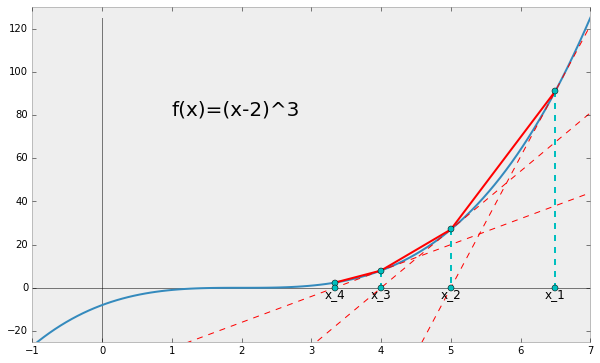

In [3]:
def fn(x): 
    return (x-2)**3; 
def d1(x): 
    return 3*(x-2)**2; 
newton_example(fn,d1)

> Remark
> - Here is how Newton's method works
>     - Given some initial point $x_1$, we first find the tangent line $\ell_1(x)$ of $f(x)$ at $x_1$.
>     - Let $x_2$ denote the root of $\ell_1(x)$, i.e. $\ell_1(x_2)=0$
>     - Find the tangent line $\ell_2(x)$ of $f(x)$ at $x_2$.
>     - Let $x_3$ denote the root of $\ell_2(x)$, i.e. $\ell_1(x_3)=0$

### Newton's Method: Finding Stationary Point

- We have shown how to use Newton's method to find the root for $f(x)$
    $$
    x_{n+1}= x_n - \frac{f(x_n)}{f'(x_n)}
    $$

- **Note** that Stationary point of $f(x)$ is equivalent to root of $f'(x)$

- So, we could find stationary point of $f(x)$ by finding root of $f'(x)$ using Newton's method.

- The iteration steps becomes
    $$
    x_{n+1}= x_n - \frac{f'(x_n)}{f''(x_n)}
    $$
    
- For *multi-dimension* case, this iteration turns into
    $$
    \vx_{n+1}= \vx_n - \left(\nabla^2 f(\vx_n)\right)^{-1} \nabla_\vx f(\vx_n)
    $$
    of which $\nabla^2 f(\vx_n)$ is **Hessian matrix** which is the *second order derivative*
    $$
    \nabla^2 f = \begin{bmatrix}
    \frac{\partial f}{\partial x_1\partial x_1} & \cdots & \frac{\partial f}{\partial x_1\partial x_n}\\ 
    \vdots & \ddots & \vdots\\ 
    \frac{\partial f}{\partial x_n\partial x_1} & \cdots & \frac{\partial f}{\partial x_n\partial x_n}
    \end{bmatrix}
    $$

### Logistic Regression: Applying Newton's Method

- Back to logistic regression!

- Recall our goal to minimize $E(\vw)$ and we already have its gradient
    $$
    \nabla_\vw E(\vw) = \sum \nolimits_{n=1}^N \left[\sigma(\vw^T\phi(\vx_n)) - t_n \right] \phi(\vx_n) = \Phi^T \left( \sigma(\Phi \vw) - \vt \right)
    $$
    
- To minimize of $E(\vw)$, we could use Newton's method to find its *stationary point*!

- To use Newton's method, we need the *Hessian matrix*.

### Logistic Regression: Hessian Matrix
$$
\begin{align}
\nabla^2 E(\vw) 
&= \nabla_\vw \nabla_\vw E(\vw) \\
&= \nabla_\vw \sum \nolimits_{n=1}^N \left[\sigma(\vw^T\phi(\vx_n)) - t_n \right] \phi(\vx_n) \\
&= \sum \nolimits_{n=1}^N \nabla_\vw \sigma(\vw^T\phi(\vx_n))  \phi(\vx_n) \\
&= \sum \nolimits_{n=1}^N \nabla_\vw  \frac{1}{1 + \exp(-\vw^T \phi(\vx_n))}  \phi(\vx_n) \\
&= \sum \nolimits_{n=1}^N \phi(\vx_n) \frac{\exp(-\vw^T \phi(\vx_n))}{(1 + \exp(-\vw^T \phi(\vx_n)))^2}  \phi(\vx_n)^T \\
&= \sum \nolimits_{n=1}^N \phi(\vx_n) \frac{1}{1 + \exp(-\vw^T \phi(\vx_n))} \frac{\exp(-\vw^T \phi(\vx_n))}{1 + \exp(-\vw^T \phi(\vx_n))}   \phi(\vx_n)^T \\
&= \sum \nolimits_{n=1}^N \phi(\vx_n) [\sigma(\vw^T \phi(\vx_n)) \cdot ( 1 - \sigma(\vw^T \phi(\vx_n)) )]  \phi(\vx_n)^T \\
&= \sum \nolimits_{n=1}^N \phi(\vx_n) r_n(\vw) \phi(\vx_n)^T
\end{align}
$$
- of which $r_n(\vw) = \sigma(\vw^T \phi(\vx_n)) \cdot ( 1 - \sigma(\vw^T \phi(\vx_n)) )$

$$
\begin{align}
H_\vw E(\vw) 
&= \sum \nolimits_{n=1}^N \phi(\vx_n) r_n(\vw) \phi(\vx_n)^T \\
&= \begin{bmatrix}
| &  & | \\ 
\phi(\vx_1) & \cdots & \phi(\vx_N)\\ 
| &  & |
\end{bmatrix}
\begin{bmatrix}
r_1(\vw) &  & \\ 
 & \ddots & \\ 
 &  & r_N(\vw)
\end{bmatrix}
\begin{bmatrix}
- & \phi(\vx_1)^T & -\\ 
 & \vdots & \\ 
- & \phi(\vx_N)^T & -
\end{bmatrix} \\
&= \boxed{\Phi^T R(\vw) \Phi}
\end{align}
$$

- of which
    $$
    R(\vw) = \begin{bmatrix}
    r_1(\vw) &  &  & \\ 
     & r_2(\vw) &  & \\ 
     &  & \ddots & \\ 
     &  &  & r_N(\vw)
    \end{bmatrix}
    $$
    

### Logistic Regression: Applying Newton's Method

- We already have
    $$
    \begin{gather}
    \nabla_\vw E(\vw) = \Phi^T \left( \sigma(\Phi \vw) - \vt \right) \\
    H_\vw E(\vw) = \Phi^T R(\vw) \Phi
    \end{gather}
    $$
    
- So the iteration step is
    $$
    \begin{align}
    \vw_{n+1}
    &= \vw_n - \left(H_\vw E(\vw_n)\right)^{-1} \nabla_\vw f(\vw_n) \\
    &= \boxed{\vw_n - \left(\Phi^T R(\vw_n) \Phi \right)^{-1} \Phi^T \left( \sigma(\Phi \vw_n) - \vt \right)}
    \end{align}
    $$
    
- Repeat until convergence and we could get maximum likelihood estimate $\vw_{ML}$ which minimizes the loss function $E(\vw)$ and maximizes likelihood function $ P(\vy = \vt| \mathcal{X}, \vw)$

### Logistic Regression: Do we have closed-form solution?

- Recall for **ordinary least squares** and **regularized least squares**, we have closed-form solution:

|               | Ordinary Least Squares  |  Regularized Least Squares |
| ------------- | :-------------: | :-------------: |
| **Derivate of Loss Function** | $\Phi^T\Phi \vec{w} - \Phi^T \vec{t}$ | $(\Phi^T \Phi + \lambda I)\vec{w} - \Phi^T \vec{t}$ |
| **Closed-form Solution**      | $(\Phi^T \Phi)^{-1} \Phi^T \vec{t}$   | $(\Phi^T \Phi + \lambda I)^{-1} \Phi^T \vec{t}$     |

- They are obtained by finding the closed-form root of derivative of loss function。

- For logistic regression, we have
    $$
    \begin{gather}
    \nabla_\vw E(\vw) = 0 \\
    \Downarrow \\
    \Phi^T \left( \sigma(\Phi \vw) - \vt \right) = 0
    \end{gather}
    $$
    
- Existence of sigmoid function makes $\nabla_\vw E(\vw)$ **nonlinear** and no closed-form solution exists.

- So we must **iterate**!

### Appendix: Multi-class Classification using Logistic Regression

- We have seen sigmoid function enables us to do binary classification with logistic regression.

- What if we want have multiple classes?

- We will resort to **softmax** aka **normalized exponential** function

- **Softmax Function**
    $$
    p_k = \frac{\exp(q_k)}{\sum_j \exp(q_j)}
    $$
    Given any real numbers $q_1, \ldots, q_n$, we can generate a distribution on them using softmax function.
    
- Recall in binary case, we have
    $$
    P(y = 1 | \vx,\vw) = \sigma(\vw^T \phi(\vx))
    $$
    
- For K-class classification, we define $\mathcal{W} = {\vw}_{k=1}^K$. 

- The probablity data $\vx$ belongs to class $j$ is
    $$
    P(y = j | \vx,\mathcal{W}) = \frac{\exp(\vw_j^T \phi(\vw))}{\sum_{k=1}^{K} \exp(\vw_k^T \phi(\vw))}
    $$
    
- We classify using
    $$
    y = \underset{j \in \{1,\dots, K\}}{\arg \max} P(y = j | \vx,\mathcal{W})
    $$
    
- Similarly, $\mathcal{W} = {\vw}_{k=1}^K$ is learned by maximizing likelihood function.

- For details, please refer to [this](http://ufldl.stanford.edu/wiki/index.php/Softmax_Regression)